# Money Flow Index:


#### This idea was taken from web which gives free trading strategies ideas, specifically the "quantitative" ones, the link which I get the idea is the following one: https://www.quantifiedstrategies.com/quantitative-trading-strategies/

#### The strategy says the following:     
*If the two-day MFI is below 10, we buy at the close
We sell at the close when the close ends higher than yesterday’s high
We have a time stop of 10 trading days*


## 1. Import the libraries:

In [1]:
import backtrader as bt
import yfinance as yf

## 2. Define the strategy

In [2]:
class MoneyFlowIndex(bt.Strategy):
    params = (
        ("mfi_period", 2),
        ("threshold_low", 10),
        ("time_stop_days", 10),
    )

    def __init__(self):
        self.dataclose = self.data.close
        self.bought = False
        self.last_buy_date = None

        self.high_price = self.data.high
        self.low_price = self.data.low
        self.volume = self.data.volume

        self.typical_price = (self.high_price + self.low_price + self.dataclose) / 3.0
        self.raw_money_flow = self.typical_price * self.volume

        self.positive_flow = bt.ind.SumN(
            self.raw_money_flow * (self.typical_price > self.typical_price(-1)),
            period=self.params.mfi_period
        )
        self.negative_flow = bt.ind.SumN(
            self.raw_money_flow * (self.typical_price < self.typical_price(-1)),
            period=self.params.mfi_period
        )

        self.money_flow_ratio = bt.DivByZero(
            self.positive_flow, self.negative_flow, zero=1.0
        )
        self.lines.mfi = 100.0 - 100.0 / (1.0 + self.money_flow_ratio)


    def next(self):
        if self.lines.mfi[0] < self.params.threshold_low and not self.bought:
            self.buy()
            self.bought = True
        
        if self.bought and self.last_buy_date is not None:
            elapsed_days = (self.data.datetime.datetime() - self.last_buy_date).days
            if elapsed_days >= self.params.time_stop_days:
                self.sell()
                self.bought = False
                
        if self.bought == True and self.data.close[0] > self.data.high[-1]:
            self.sell()
            self.bought = False
            



## 3. Create cerebro & run backtest

In [3]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    ticker = "ES=F"
    starting ="2015-01-01"
    ending = "2020-01-01"
    ## 3. Create cerebro & run backtest
    data = yf.download(ticker, start= starting, end= ending)
    data = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data)
    cerebro.addstrategy(MoneyFlowIndex)

    starting_cash = 10000
    cerebro.broker.set_cash(starting_cash)
    #cerebro.broker.setcommission(commission=0.001)  # 0.1% commission
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

    cerebro.run()

    print(f"Ending Portfolio Value: {cerebro.broker.getvalue():.2f}")

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
Ending Portfolio Value: 10210.25


## Results:

<IPython.core.display.Javascript object>


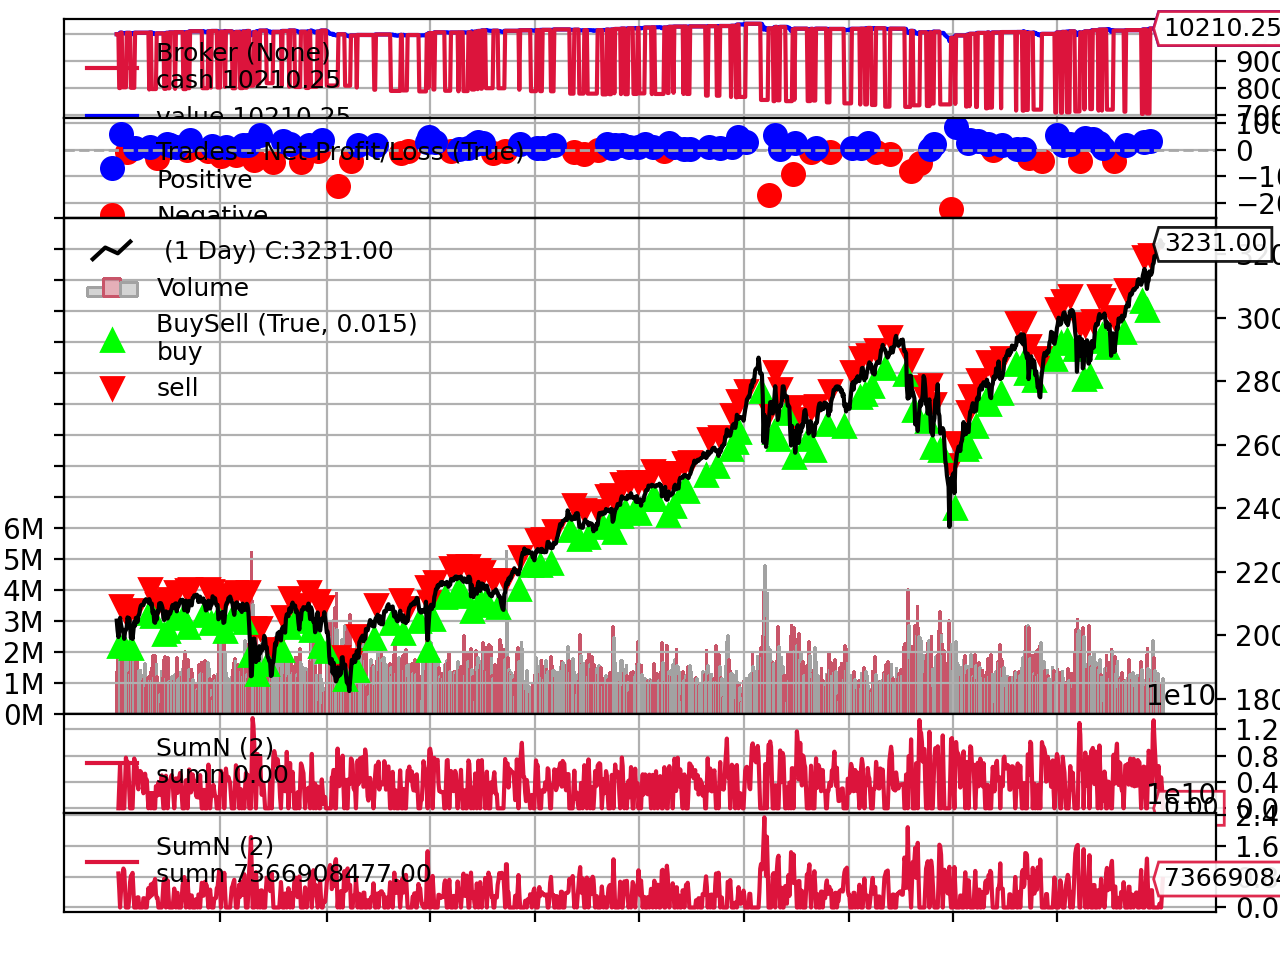

[[<Figure size 640x480 with 6 Axes>]]

In [4]:
cerebro.plot()

### Getting some basic annalysis:

In [5]:
annalize = cerebro.run()

In [6]:
for strat in annalize:
    print(f"Final Portfolio Value: {strat.broker.getvalue():.2f}")
    print(f"Total Return: {strat.broker.getvalue() - starting_cash:.2f}")
    print(f"Annualized Return: {(strat.broker.getvalue() / starting_cash) ** (252 / len(data)) - 1:.2%}")

Final Portfolio Value: 10210.25
Total Return: 210.25
Annualized Return: 0.42%


## Conclusion:

As we can see, this strategy doesn't seems to have a competitive advantadge against other possible strategies giving a bad result without without taking into account the inflation and the broker commissions.